In [1]:
#basic libraries
import h2o
import numpy as np
import pandas as pd
import re

#scikit-learn libraries
from sklearn.preprocessing import LabelBinarizer, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer

#h2o models and grid search
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators import H2OXGBoostEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.grid.grid_search import H2OGridSearch

#plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Model Training
After finishing the data preprocessing and imputation, I will train the model. I will use 3 algorithms to compare the result, and use the top 2 as baseline models. The algorithms are gradient boosting, deep learning, and XGBoost. For the first 2 algorithms, I will use the H2O library. For the XGBoost algorithm, I will use the XGBoost library since it is not supported in the current version of H2O (I'm using windows). In the next notebook, I will perform feature engineering to add features to the dataset, hopefully making the model better. If the model is not better, I will use the best of the baseline models to create a prediction pipeline.

In [2]:
#reading the final dataset
df_use = pd.read_csv('final_data.csv')

In [3]:
#initializing H2O. Reminder: H2O needs java.
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.8+9-LTS-211, mixed mode, sharing)
  Starting server from C:\Users\agust\Anaconda3\envs\h2o_loan_classification\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\agust\AppData\Local\Temp\tmp591bpbbu
  JVM stdout: C:\Users\agust\AppData\Local\Temp\tmp591bpbbu\h2o_agust_started_from_python.out
  JVM stderr: C:\Users\agust\AppData\Local\Temp\tmp591bpbbu\h2o_agust_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Asia/Jakarta
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.2
H2O_cluster_version_age:,1 month and 12 days
H2O_cluster_name:,H2O_from_python_agust_zkpbtv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.854 Gb
H2O_cluster_total_cores:,0
H2O_cluster_allowed_cores:,0
H2O_cluster_status:,"locked, healthy"


In [4]:
#parsing the dataframe to H2O dataframe
hf = h2o.H2OFrame(df_use)

#separating predictors and response
predictors = list(df_use.columns[1:])
response = "loan_status"

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [5]:
#create train, test, and validation dataset
train_temp, test = hf.split_frame(ratios = [.8], seed = 42)
train, val = train_temp.split_frame(ratios = [.8], seed = 42)

## Using Gradient Boosting Model
For this part, I will use H2OGridSearch combined with H2OGradientBoostingEstimator to train the model. I will set the hyperparameters to tune first, initialize the grid search, and train the model. For the model training phase, I will use the validation dataset instead of the testing dataset. Next, I will select the best model out of the results and use it to evaluate the model performance on the test dataset. Lastly, I will create a feature importance plot to examine which feature contributes to the model the most.

In [6]:
#hyperparameters to tune
gbm_params1 = {'learn_rate': [0.01, 0.05, 0.1],
                'max_depth': [5, 7, 9],
                'ntrees': [300, 500, 700],
                'sample_rate': [0.5, 0.8, 1.0],
                'col_sample_rate': [0.25, 0.5, 1.0]}

#initializing grid search
gbm_grid1 = H2OGridSearch(
    model=H2OGradientBoostingEstimator,
    grid_id='gbm_grid1',
    hyper_params=gbm_params1
)

In [7]:
#model training
gbm_grid1.train(
    x=predictors,
    y=response,
    training_frame=train,
    validation_frame=val,  # Include your validation frame here
    seed=42
)

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


,col_sample_rate,learn_rate,max_depth,ntrees,sample_rate,model_ids,logloss
,1.0,0.01,9.0,700.0,0.8,gbm_grid1_model_156,0.5416276
,0.5,0.01,9.0,700.0,0.8,gbm_grid1_model_155,0.5419503
,1.0,0.01,9.0,500.0,0.8,gbm_grid1_model_129,0.5421302
,0.5,0.05,7.0,300.0,1.0,gbm_grid1_model_176,0.5423889
,1.0,0.05,5.0,300.0,1.0,gbm_grid1_model_168,0.5424562
,0.5,0.01,7.0,700.0,1.0,gbm_grid1_model_227,0.5424758
,0.5,0.01,9.0,700.0,1.0,gbm_grid1_model_236,0.5425033
,0.5,0.01,9.0,500.0,0.8,gbm_grid1_model_128,0.5426462
,1.0,0.05,5.0,500.0,0.8,gbm_grid1_model_114,0.5427060
,1.0,0.05,5.0,700.0,0.8,gbm_grid1_model_141,0.5427060


In [8]:
gbm_gridperf1 = gbm_grid1.get_grid(sort_by='aucpr', decreasing=True)
gbm_gridperf1

,col_sample_rate,learn_rate,max_depth,ntrees,sample_rate,model_ids,aucpr
,0.25,0.01,9.0,700.0,0.8,gbm_grid1_model_154,0.4908916
,0.5,0.01,9.0,700.0,0.8,gbm_grid1_model_155,0.4905253
,0.5,0.01,7.0,700.0,1.0,gbm_grid1_model_227,0.4904542
,0.5,0.01,9.0,500.0,0.8,gbm_grid1_model_128,0.4895133
,1.0,0.05,5.0,300.0,1.0,gbm_grid1_model_168,0.4894263
,0.25,0.05,7.0,500.0,1.0,gbm_grid1_model_202,0.4892838
,0.25,0.05,7.0,700.0,1.0,gbm_grid1_model_229,0.4892838
,1.0,0.01,7.0,700.0,0.5,gbm_grid1_model_66,0.4889319
,1.0,0.01,9.0,700.0,0.8,gbm_grid1_model_156,0.4889265
,1.0,0.05,5.0,700.0,0.5,gbm_grid1_model_60,0.4889039


In [9]:
#get the best model
best_gbm1 = gbm_gridperf1.models[0]

#evaluate the model against the test data
perf = best_gbm1.model_performance(test)
print(perf)

ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.18217842565624304
RMSE: 0.42682364702092485
LogLoss: 0.5436652495002108
Mean Per-Class Error: 0.3707760370083102
AUC: 0.692562817328524
AUCPR: 0.47959687988212923
Gini: 0.38512563465704797

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24279204886962436
              loan_given    loan_refused    Error    Rate
------------  ------------  --------------  -------  ----------------
loan_given    6439          6340            0.4961   (6340.0/12779.0)
loan_refused  1234          3794            0.2454   (1234.0/5028.0)
Total         7673          10134           0.4253   (7574.0/17807.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.242792     0.500462  258
max f2                       0.138046     0.677676  340
max f0point5                 0.381356     0.46

The AUC score for this model is 0.6925, which is not bad. Based on the confusion matrix, I can see that the model does a pretty good job in predicting a refused loan when the loan is supposed to be refused. However, the performance is not too god for predicting loans which are given. The number of false positives are almost the same as the number of true positives.

I will generate the shap summary plot to see what features are the most important in affecting the result of the model's prediction.

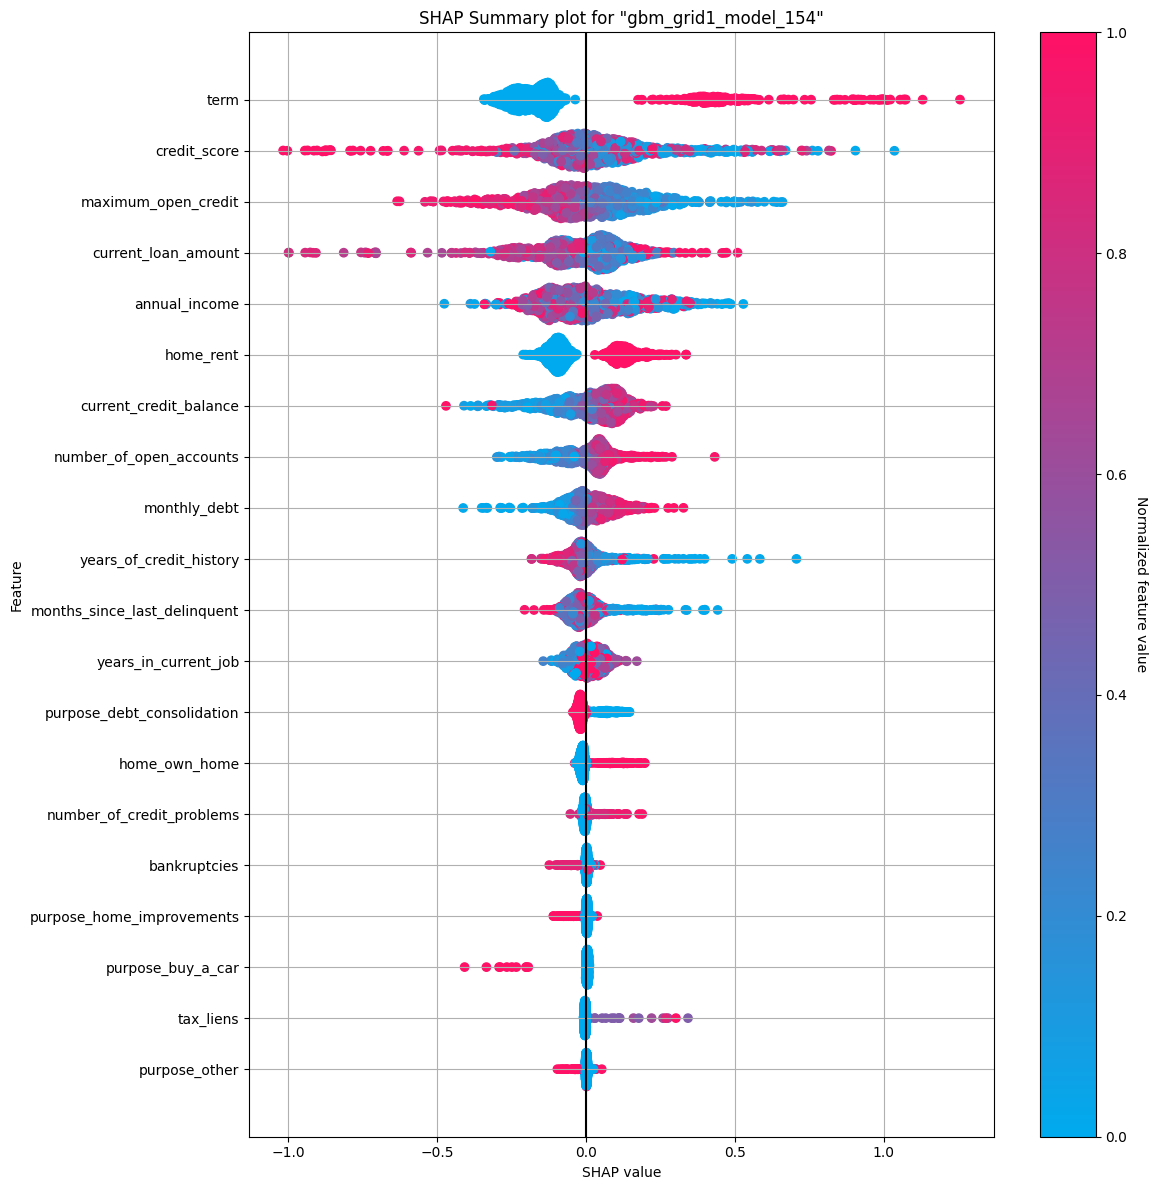

In [10]:
best_gbm1.shap_summary_plot(test)

The takeaway from shap summary plot are as follows:
1. The top 3 features that affect the prediction result of the model is term, credit score, and maximum open credit. These are the top 3 most important features.
2. Starting from purpose_debt_consolidation to purpose_other, these features don't affect the prediction result of the model.
3. The beeswarm is a bit different. As far as I know, the right part of the plot (after the 0.0 value on the X axis) is for class 1, which is loan_given, and vice versa. But this summary plot shows that when the loan term is long (red dots), the model predicts that the loan is given. However, based on the barchart, I think that the shorter term loans tend to be given. [See this image for reference](/images/term_loanstatus_barchart.png). I have to check this further.

Nevertheless, I will continue to create a bar chart for the most important features.

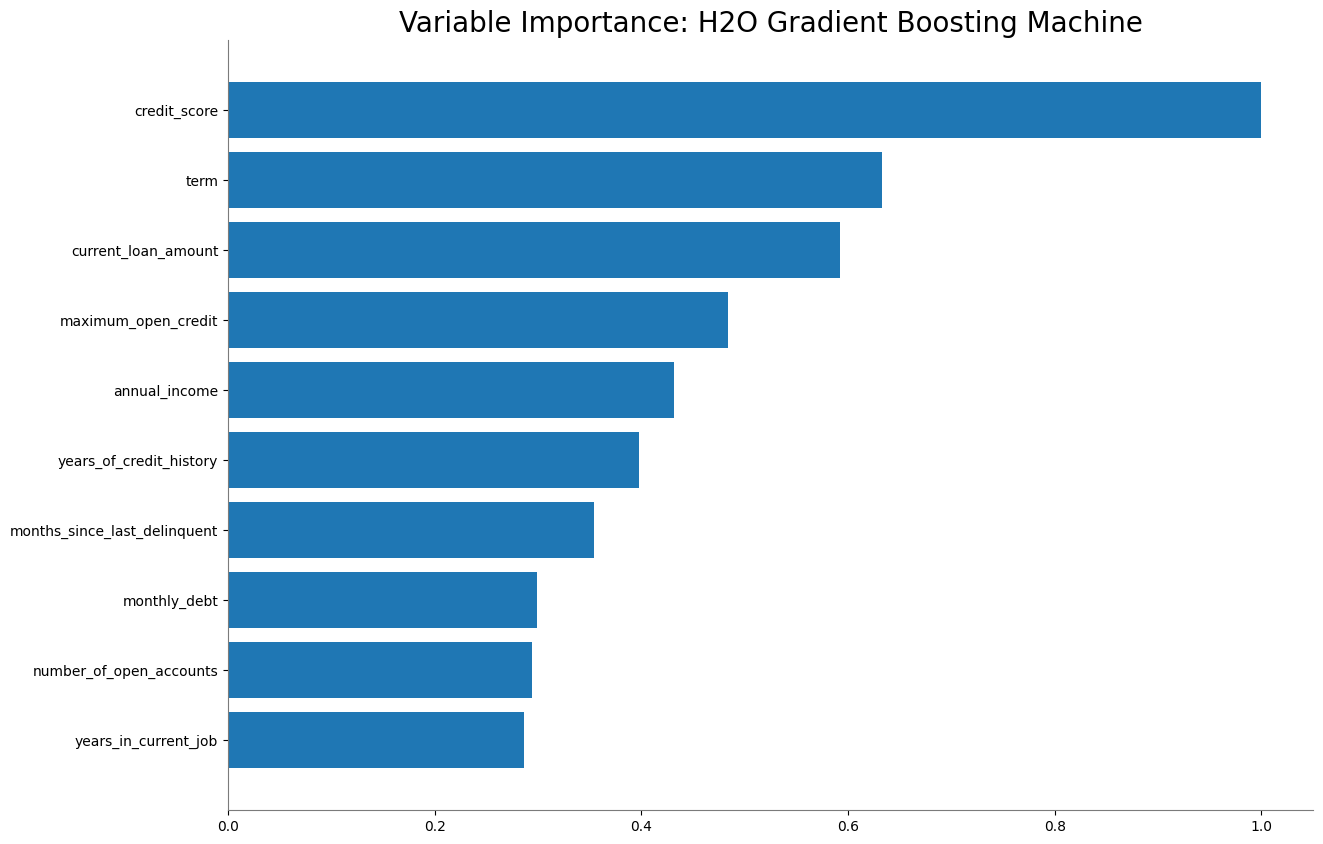

<Figure size 640x480 with 0 Axes>

In [29]:
best_gbm1.varimp_plot()

Based on the more traditional method, which is how often a feature is used to split the trees in this case, the most important features are credit score, term, and current loan amount.

In [14]:
#saving model
model_path = h2o.save_model(
  best_gbm1,
  path = "model",
  force = True,
  export_cross_validation_predictions = False
)
model_path

'C:\\Online Course\\Projects\\loan-classification-h20-xgboost\\model\\gbm_grid1_model_154'

# Using Deep Learning
For this part, I will use H2OGridSearch combined with H2ODeepLearningEstimator to train the model. I will set the hyperparameters to tune first, initialize the grid search, and train the model. For the model training phase, I will use the validation dataset instead of the testing dataset. Next, I will select the best model out of the results and use it to evaluate the model performance on the test dataset. Lastly, I will create a feature importance plot to examine which feature contributes to the model the most.

In [15]:
#hyperparameters to tune
hyper_params = {
    'hidden': [[16, 16], [16, 32, 64], [16, 32, 64, 128]],
    'epochs': [50, 100, 200],
    'balance_classes': [True, False],
    'activation': ['Rectifier', 'Tanh', 'RectifierWithDropout','Maxout']
}

#initialize grid search
dl_grid = H2OGridSearch(
    model=H2ODeepLearningEstimator,
    grid_id='dl_grid',
    hyper_params=hyper_params
)

In [16]:
#train the model
dl_grid.train(
    x=predictors,
    y=response,
    training_frame=train,
    validation_frame=val
)

deeplearning Grid Build progress: |██████████████████████████████████████████████| (done) 100%


,activation,balance_classes,epochs,hidden,model_ids,logloss
,Rectifier,false,100.0,"[16, 32, 64]",dl_grid_model_37,0.5530803
,Tanh,true,100.0,"[16, 32, 64, 128]",dl_grid_model_58,0.5532618
,Tanh,true,50.0,"[16, 32, 64, 128]",dl_grid_model_50,0.5534685
,Tanh,true,200.0,"[16, 16]",dl_grid_model_18,0.5540685
,Rectifier,false,200.0,"[16, 32, 64, 128]",dl_grid_model_69,0.5546092
,Rectifier,true,200.0,"[16, 16]",dl_grid_model_17,0.5552002
,Rectifier,false,50.0,"[16, 32, 64, 128]",dl_grid_model_53,0.5552465
,Maxout,false,50.0,"[16, 32, 64, 128]",dl_grid_model_56,0.5553784
,Maxout,true,200.0,"[16, 32, 64, 128]",dl_grid_model_68,0.5556773
,Rectifier,false,200.0,"[16, 32, 64]",dl_grid_model_45,0.5557063


In [17]:
# Get the best model from the grid search
best_dl_model = dl_grid.get_grid()[0]

#evaluate model performance against the test data
perf = best_dl_model.model_performance(test)
print(perf)

ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.18573503207019926
RMSE: 0.4309698737385239
LogLoss: 0.5536959148480648
Mean Per-Class Error: 0.37470236322108363
AUC: 0.6765012012236912
AUCPR: 0.457379331028458
Gini: 0.35300240244738235

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2638401817359079
              loan_given    loan_refused    Error    Rate
------------  ------------  --------------  -------  ----------------
loan_given    7002          5777            0.4521   (5777.0/12779.0)
loan_refused  1495          3533            0.2973   (1495.0/5028.0)
Total         8497          9310            0.4084   (7272.0/17807.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.26384      0.492816  243
max f2                       0.14015      0.671581  335
max f0point5                 0.360745  

The AUC score of the deep learning model is lower compared to the gradient boosting model. So, I will not save this model first. I will plot the feature importance. Since shap is not supported here, I will go straight to plot the bar chart of the feature importance.

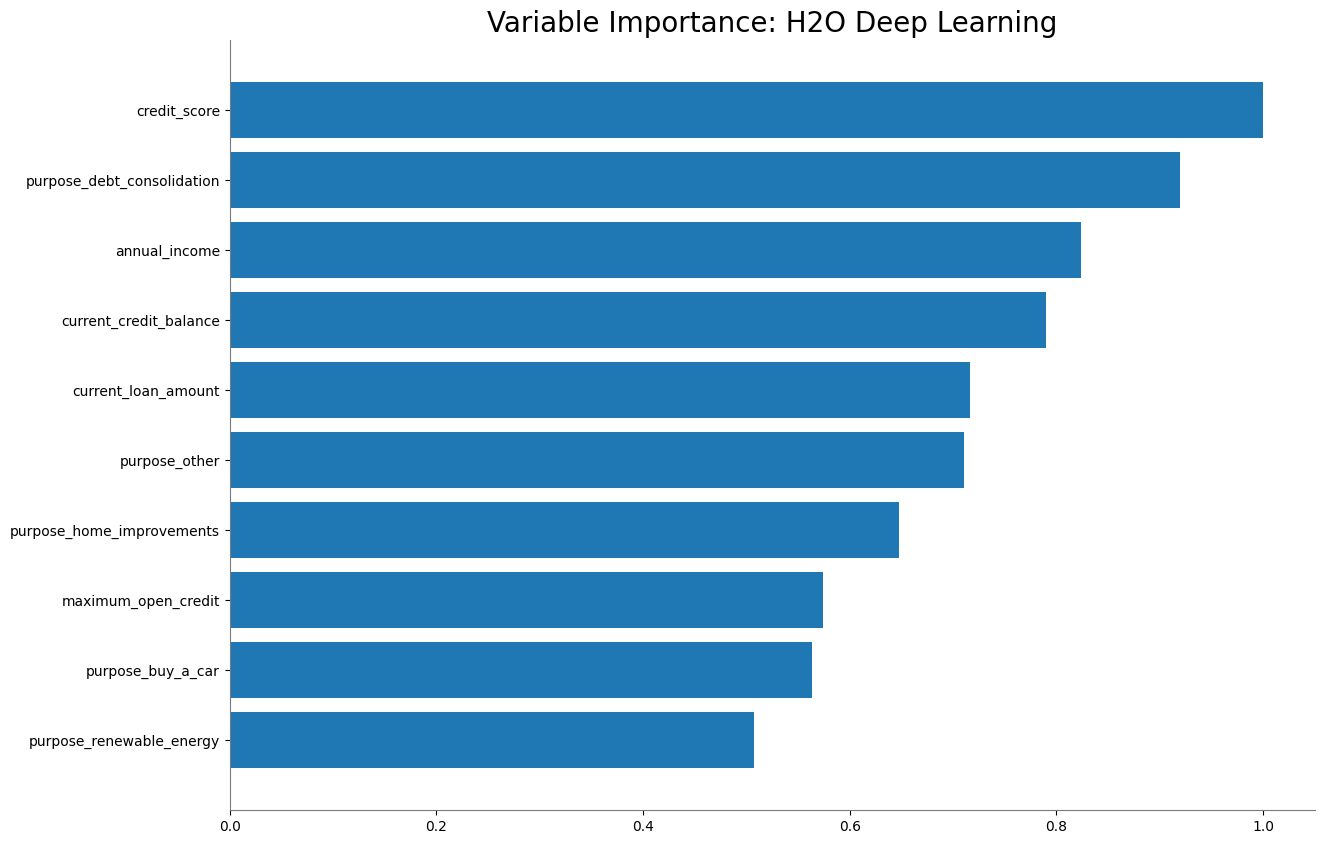

<Figure size 640x480 with 0 Axes>

In [30]:
best_dl_model.varimp_plot()

The result of this feature importance plot is a bit different compared to the gradient boosting one. The most important feature is still credit score. However, it's followed by purpose_debt_consolidation and annual_income.

# Using XGBoost
For this part, I will use GridSearchCV from scikit-learn combined with XGBoostClassifier to train the model. I will set the hyperparameters to tune first, initialize the grid search, and train the model. For the model training phase, I will use the validation dataset instead of the testing dataset. Next, I will select the best model out of the results and use it to evaluate the model performance on the test dataset. Lastly, I will create a feature importance plot to examine which feature contributes to the model the most. Since there are no built-in methods to plot the feature importance, I will use the SHAP library to do that.

In [19]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import joblib
import shap
import pandas as pd
import numpy as np
%matplotlib inline

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [20]:
#reading the final dataset
df_use = pd.read_csv('final_data.csv')

#separate predictors and target
X = df_use.drop('loan_status', axis=1)
y = pd.DataFrame(df_use['loan_status'])

#mapping the target variable to 0 and 1 so that the algorithm works
mapping = {
    'loan_refused': 0,
    'loan_given': 1
}
y['loan_status'] = y['loan_status'].map(mapping)

#split the dataset into train, test, and validation
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.2, random_state=42)

print(f'The number of training dataset is {X_train.shape[0]}, the number of validation dataset is {X_val.shape[0]}, and the number of testing dataset is {X_test.shape[0]}.')

The number of training dataset is 56900, the number of validation dataset is 14226, and the number of testing dataset is 17782.


In [21]:
#hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [2, 3, 4],
    'subsample': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5],
    'learning_rate': [0.1, 0.01],
    'max_bin': [128, 256, 512]
}

# Initialize the XGBoost classifier
xgb = XGBClassifier(random_state=42, eval_metric='auc', early_stopping_rounds=10)

# Initialize GridSearchCV with the XGBoost classifier and parameter grid
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='roc_auc', cv=3, verbose=1)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train,eval_set=[(X_val, y_val)], verbose = 0)

Fitting 3 folds for each of 1458 candidates, totalling 4374 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=10,
                                     enable_categorical=False,
                                     eval_metric='auc', feature_types=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, m...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.1, 0.01],
                         'max_bin': [128, 256, 512], 'max_depth': [2, 3, 4],
                         'n_estimators': [100, 200, 300],
                         'reg_alpha': [0, 0.1, 0.5],
                         'reg_lambda': [0, 0.1, 0.5],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='roc_auc', verbose=1)

In [22]:
# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best AUC Score:", grid_search.best_score_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
test_auc = best_model.score(X_test, y_test)
print("Test AUC Score:", test_auc)

Best Parameters: {'learning_rate': 0.1, 'max_bin': 128, 'max_depth': 4, 'n_estimators': 200, 'reg_alpha': 0.5, 'reg_lambda': 0.1, 'subsample': 0.8}
Best AUC Score: 0.6830546719675046
Test AUC Score: 0.7343943313463053


### XGBoost Model Explanation
Since there is no built-in method to explain this model, I will use the shap library to do so. Similar to the previous 2 models, I will use the shap summary plot and bar plot to explain the model.

In [23]:
import shap

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


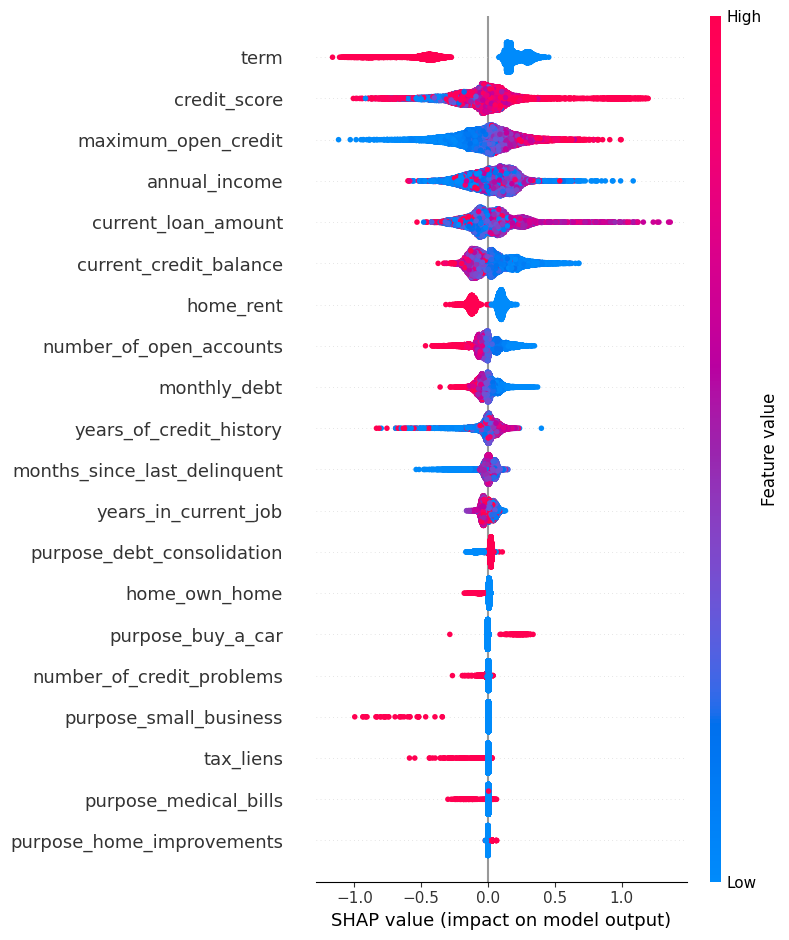

In [25]:
explainer = shap.Explainer(best_model)
shap_values = explainer(X_val)

#shap summary plot
shap.summary_plot(shap_values, X_val)

The key takeaways from the plot above:
1. The top 3 features of this model is term, credit score, and maximum_open_credit.
2. Begining on the purpose_debt_consolidation to purpose_home_improvements, these features don't affect the prediction much, since the examples are mostly located around 0.
3. When the loans are long term, it makes the model predicts the application as not given (loan_refused). Whereas when the loans are short term, it makes the model predicts the application as given (loan_given).
4. Higher credit score is also associated with the model predicts the loan application to be given, although there are obvious examples that people with higher credit score also get their loans rejected as well. 
5. Higher maximum open credit is also associated with the model predicts the loan application to be given.

One thing to note here, the shap summary plot is quite identical with the gradient boosting one, especially for the top important features. However, it's inversed. I need to check this further. But assuming that the shap summary plot built-in the H2O library is indeed inversed, then I can say that it's very similar to the gradient boosting one.

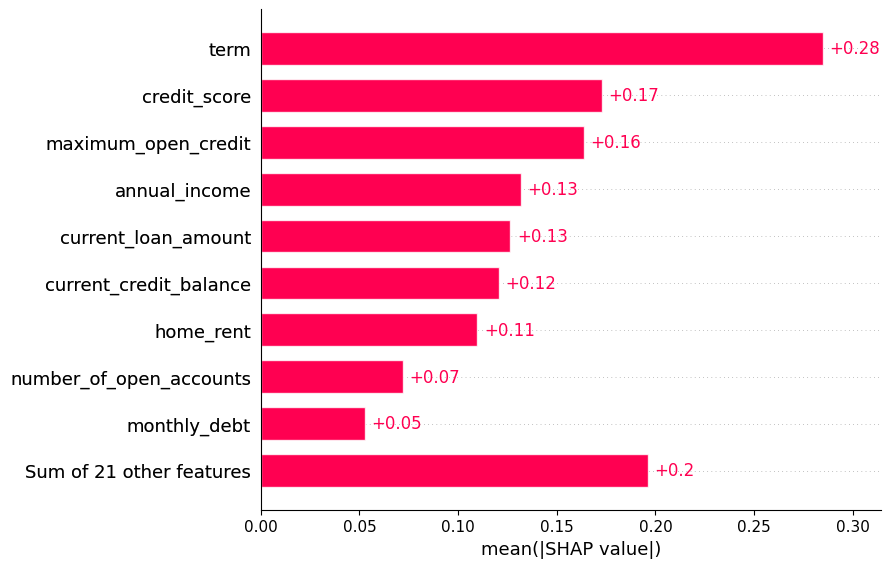

In [26]:
#bar chart for shap values
shap.plots.bar(shap_values)

The bar plot also shows the most important features and how they affect the model. Note that the feature importance scores result here is the same as the summary plot. This is because the bar chart also use SHAP instead of a more traditional method.

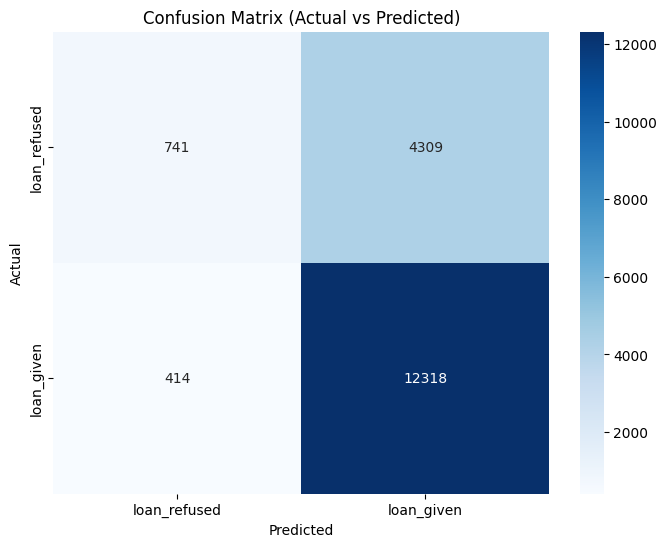

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# evaluate the model on the test dataset
y_pred = best_model.predict(X_test)

# Calculate the confusion matrix
confusion = confusion_matrix(y_test, y_pred)

class_names = ['loan_refused', 'loan_given']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Actual vs Predicted)')
plt.show();

Based on the confusion matrix, I think the model correctly predicts when the loan is given when it's supposed to be given. However, it does a pretty poor job in predicting when the loan is refused when it's supposed to be refused. In other words, the number of false negatives is way higher than the true negatives.

After examining the result, based on the AUC score, the models that I'm going to use as the base models are the gradient boosting model and the XGBoost model. 

In the next notebook, I'm going to add features to the dataset to try to increase the performances of the models.

In [28]:
#saving the model
import joblib

joblib.dump(best_model, 'model/best_xgb_model.pkl')

['model/best_xgb_model.pkl']